In [2]:
import numpy as np

In [3]:
x = np.load("TestSWModel/a11.npy", allow_pickle=True)

In [4]:
data = dict(x.item(0))

In [5]:
data['diffs'][0][1]

9791035

In [ ]:
plt.imshow(out

In [6]:
import tensorflow as tf

2023-09-07 14:00:52.559732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
interpreter = tf.lite.Interpreter(model_path="sa_model.tflite")

In [8]:
interpreter.allocate_tensors()

In [9]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [10]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 250, 250,   3], dtype=int32),
  'shape_signature': array([ -1, 250, 250,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_input_6:0',
  'index': 1,
  'shape': array([  1, 250, 250,   3], dtype=int32),
  'shape_signature': array([ -1, 250, 250,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'serving_default_input_4:0',
  'index': 2,
  'shape': array([  1, 250, 250,   3], dtype=int32),
  'shape_signature': array([ -1, 250, 250,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0,

In [12]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 225,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

In [11]:
input_width

250

In [13]:
class SAanalysis:
    def __init__(self, diff_len, centers_len, frames_len):
        self.diffs_len = diff_len
        self.centers_len = centers_len
        self.frames_len = frames_len
        self.diffs = []
        self.centers = []
        self.frames = []

    def diffAppend(self, value):
        if len(self.diffs) < self.diffs_len:
            self.diffs.append(value)
        elif len(self.diffs) == self.diffs_len:
            self.diffs.pop(0)
            self.diffs.append(value)

    def centerAppend(self, value):
        if len(self.centers) < self.centers_len:
            self.centers.append(value)
        elif len(self.centers) == self.centers_len:
            self.centers.pop(0)
            self.centers.append(value)

    def framesAppend(self, value):
        if len(self.frames) < self.frames_len:
            self.frames.append(value)
        elif len(self.frames) == self.frames_len:
            self.frames.pop(0)
            self.frames.append(value)

    def inference(self):
        diffs_avg = np.average(self.diffs)

        n_center = []
        for i,k in zip(self.centers[0::], self.centers[1::]):
            d = np.linalg.norm(np.array(i) - np.array(k))
            n_center.append(d)
            

        centers_avg = np.average(n_center)    

        t_diffs = tf.convert_to_tensor([diffs_avg], dtype=tf.float32)
        t_centers = tf.convert_to_tensor([centers_avg], dtype=tf.float32)

        t_frames = [tf.image.per_image_standardization(tf.image.resize(tf.convert_to_tensor(frame, dtype=tf.float32), (input_height, input_width))) for frame in self.frames]

        d = {'frames':[t_frames[0][tf.newaxis, ...],t_frames[1][tf.newaxis, ...],t_frames[2][tf.newaxis, ...],t_frames[3][tf.newaxis, ...],t_frames[4][tf.newaxis, ...],t_frames[5][tf.newaxis, ...]], 'diffs': t_diffs[tf.newaxis, ...], 'centers' :t_centers[tf.newaxis, ...]}
        return dict(d)

In [14]:
from matplotlib import pyplot as plt

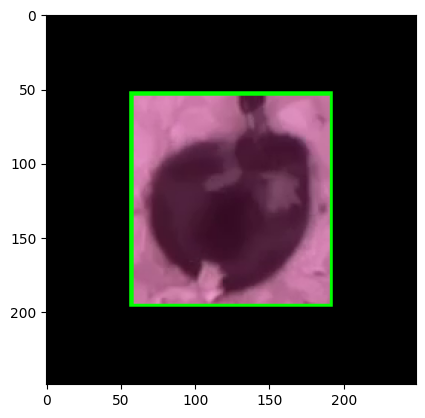

In [39]:
plt.imshow(test)

In [15]:
sa_analyser = SAanalysis(60, 30, 6)

In [16]:
for x in range(6):
    sa_analyser.framesAppend(data['frames'][x][1])
for x in range(60):
    sa_analyser.diffAppend(data['diffs'][x][1])
for x in range(30):
    sa_analyser.centerAppend(data['centers'][x][1])

In [17]:
sa_out = sa_analyser.inference()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-06 13:59:03.935904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 13:59:03.938480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-06 13:59:03.938744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
sa_out

{'frames': [<tf.Tensor: shape=(1, 250, 250, 3), dtype=float32, numpy=
  array([[[[-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           ...,
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561]],
  
          [[-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           ...,
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561]],
  
          [[-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           ...,
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.5920561],
           [-0.5920561, -0.5920561, -0.59

In [19]:
frames = [0,1,2,5,6,7]
for i,x in enumerate(frames):
    interpreter.set_tensor(x, sa_out['frames'][i])
interpreter.set_tensor(3, sa_out['centers'])
interpreter.set_tensor(4, sa_out['diffs'])

In [15]:
diffs_avg = 1902921

In [16]:
t_diffs = tf.convert_to_tensor([diffs_avg], tf.float32)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-07 16:15:17.584204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 16:15:17.586710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-07 16:15:17.586778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
t_diffs

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1902921.], dtype=float32)>

In [18]:
t_diffs[tf.newaxis, ...]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1902921.]], dtype=float32)>

In [25]:
t_diffs = np.array([diffs_avg], dtype=np.float32)

In [26]:
t_diffs

array([1902921.], dtype=float32)

In [27]:
np.expand_dims(t_diffs, axis=0)

array([[1902921.]], dtype=float32)

In [28]:
arr = np.array([[[ 1,  2,  3],
          [ 4,  5,  6]],
         [[ 7,  8,  9],
          [10, 11, 12]]])

In [30]:
arr.shape

(2, 2, 3)

In [36]:
mean = np.mean(arr)
stdev = np.std(arr)
arr

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])

In [37]:
(arr - mean) / stdev

array([[[-1.59325501, -1.30357228, -1.01388955],
        [-0.72420682, -0.43452409, -0.14484136]],

       [[ 0.14484136,  0.43452409,  0.72420682],
        [ 1.01388955,  1.30357228,  1.59325501]]])

In [20]:
interpreter.invoke()

In [21]:
interpreter.get_tensor(output_details[0]['index'])

array([[0.23773754]], dtype=float32)

In [22]:
print('Loading model...', end='')


# Load saved model and build the detection function
sa_model = tf.saved_model.load("sa2_saved_model/my_model/")


#Mouse Detector Initialization


Loading model...

In [25]:
from MouseDetector import MouseDetector

md = MouseDetector(None, mouseDetection=True)

OpenCV: Couldn't read movie file ""
[ERROR:0@17.801] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:293: error: (-215:Assertion failed) !_filename.empty() in function 'open'




In [26]:


def average(l):
    return sum(l)/len(l)

detectTimes = [20, 10, 5, 3, 2, 1]

numFrames = 60

count = 0

predictions = []

class SAanalysis:
    def __init__(self, model, diff_len, centers_len, frames_len):
        self.diffs_len = diff_len
        self.centers_len = centers_len
        self.frames_len = frames_len

        self.model = model

        self.diffs = []
        self.centers = []
        self.frames = []

    def diffAppend(self, value):
        if len(self.diffs) < self.diffs_len:
            self.diffs.append(value)
        elif len(self.diffs) == self.diffs_len:
            self.diffs.pop(0)
            self.diffs.append(value)

    def centerAppend(self, value):
        if len(self.centers) < self.centers_len:
            self.centers.append(value)
        elif len(self.centers) == self.centers_len:
            self.centers.pop(0)
            self.centers.append(value)

    def framesAppend(self, value):
        if len(self.frames) < self.frames_len:
            self.frames.append(value)
        elif len(self.frames) == self.frames_len:
            self.frames.pop(0)
            self.frames.append(value)

    def inference(self):
        diffs_avg = average(self.diffs)

        n_center = []
        for i,k in zip(self.centers[0::], self.centers[1::]):
            d = md.distance(i,k)
            n_center.append(d)
            

        centers_avg = average(n_center)    

        t_diffs = tf.convert_to_tensor([diffs_avg], dtype=tf.float32)
        t_centers = tf.convert_to_tensor([centers_avg], dtype=tf.float32)

        t_frames = [tf.image.per_image_standardization(tf.convert_to_tensor(frame, dtype=tf.float32)) for frame in self.frames]

        return self.model([t_frames[0][tf.newaxis, ...],t_frames[1][tf.newaxis, ...],t_frames[2][tf.newaxis, ...],t_frames[3][tf.newaxis, ...],t_frames[4][tf.newaxis, ...],t_frames[5][tf.newaxis, ...], t_diffs[tf.newaxis, ...], t_centers[tf.newaxis, ...]])

sa_analyser = SAanalysis(sa_model, 60, 30, 6)

In [27]:
for x in range(6):
    sa_analyser.framesAppend(data['frames'][x][1])
for x in range(60):
    sa_analyser.diffAppend(data['diffs'][x][1])
for x in range(30):
    sa_analyser.centerAppend(data['centers'][x][1])

In [28]:
sa_analyser.inference()

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * [<tf.Tensor 'inputs:0' shape=(1, 250, 250, 3) dtype=float32>,
 <tf.Tensor 'inputs_1:0' shape=(1, 249, 249, 3) dtype=float32>,
 <tf.Tensor 'inputs_2:0' shape=(1, 250, 249, 3) dtype=float32>,
 <tf.Tensor 'inputs_3:0' shape=(1, 249, 249, 3) dtype=float32>,
 <tf.Tensor 'inputs_4:0' shape=(1, 249, 250, 3) dtype=float32>,
 <tf.Tensor 'inputs_5:0' shape=(1, 250, 249, 3) dtype=float32>,
 <tf.Tensor 'inputs_6:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'inputs_7:0' shape=(1, 1) dtype=float32>]
    * False
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_1'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_2'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_3'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_4'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_5'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_6'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_7'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_8')]
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/0'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/1'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/2'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/3'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/4'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/5'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='inputs/6'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='inputs/7')]
    * False
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/0'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/1'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/2'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/3'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/4'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='inputs/5'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='inputs/6'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='inputs/7')]
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_1'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_2'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_3'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_4'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_5'),
 TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_6'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_7'),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_8')]
    * True
    * None
  Keyword arguments: {}